# Multi-Object Detection

## **Introduction**

Object detection is **the process of locating and classifying existing objects in an image**. Identified objects are shown with bounding boxes in the image. There are two methods for general object detection: **region proposal-based** and **regression/classification-based**. In this chapter, we will use a regression/classification-based method called YOLO.

## **Creating datasets**

We will use the **COCO dataset** to train the YOLO-v3 model. COCO is a large-scale object detection, segmentation, and captioning dataset. It contains 80 object categories for object detection. For more details on the **COCO dataset**, visit the following link: http://cocodataset.org/#home. 

In this recipe, you will learn how to **create a custom dataset**, **perform data transformation**, and **define dataloaders**.

### **Getting ready**

1. Download the following GitHub repository: https://github.com/pjreddie/darknet.
2. From the downloaded repository, get the darknet/scripts/get_coco_dataset.sh file. 
3. Create a folder named data where your scripts are located and copy get_coco_dataset.sh into the folder.
4. Next, open a Terminal and execute the get_coco_dataset.sh file from the data folder. The script will download the complete COCO dataset into a subfolder named coco.
> To run get_coco_dataset.sh on Windows, you need to install WSL
1. Create a folder named config where your scripts are located and copy the darknet/cfg/yolov3.cfg file into the config folder.

In the images folder, there should be two subfolders called train2014 and val2014 with 82783 and 40504 images, respectively.

In the labels folder, there should be two subfolders called train2014 and val2014 with 82081 and 40137 text files, respectively. These text files contain the bounding box coordinates of the objects in the images.

For instance, the COCO_val2014_000000000133.txt text file in the val2014 folder contains the following coordinates:

59 0.510930 0.442073 0.978141 0.872188
77 0.858305 0.073521 0.074922 0.059833

The first number is the object ID, while the next four numbers are normalized bounding box coordinates in [xc, yc, w, h] format, where xc, yc are the centroid coordinates and w, h are the width and height of the bounding box. 

In addition, the trainvalno5k.txt file contains a list of 117264 images that will be used to train the model. This list is a combination of the images in the train2014 and val2014 subfolders, except for 5000 images. The 5k.txt file contains a list of 5000 images that will be used for validation. 

Finally, get the coco.names file from the following link and put it in the data folder: https://github.com/pjreddie/darknet/blob/master/data/coco.names.

The coco.names file contains a list of 80 object categories in the COCO dataset.

### **How to do it**

Now that we've downloaded the COCO dataset, we will create training and validation datasets and dataloaders using PyTorch's `Dataset` and `Dataloader` classes. 

#### **Creating a custom COCO dataset**

In [1]:
# 1 1st we will define a custom dataset for COCO
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
import os
import numpy as np
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the CocoDataset class:
class CocoDataset(Dataset):
    def __init__(self, path2listFile, transform=None, trans_params=None):
        with open(path2listFile, "r") as file:
            self.path2imgs = file.readlines()
        self.path2labels = [
            path.replace("images", "labels").replace(".png", ".txt").replace(".jpg", ".txt")
            for path in self.path2imgs]
        self.trans_params = trans_params
        self.transform = transform

    def __len__(self):
        return len(self.path2imgs)

    def __getitem__(self, index):
        path2img = self.path2imgs[index % len(self.path2imgs)].rstrip()
        img = Image.open(path2img).convert('RGB')
        path2label = self.path2labels[index % len(self.path2imgs)].rstrip()
        labels = None
        if os.path.exists(path2label):
            labels = np.loadtxt(path2label).reshape(-1, 5)
        if self.transform:
            img, labels = self.transform(img, labels, self.trans_params)
        return img, labels, path2img

In [2]:
# 2 Next, we will create an object of the CocoDataset class for the training data:
root_data = "./darknet/scripts/data/coco"
path2trainList = os.path.join(root_data, "trainvalno5k.txt")
coco_train = CocoDataset(path2trainList)

In [3]:
# Get a sample item from coco_train:
img, labels, path2img = coco_train[1] 
print("image size:", img.size, type(img))
print("labels shape:", labels.shape, type(labels))
print("labels \n", labels)

image size: (640, 426) <class 'PIL.Image.Image'>
labels shape: (2, 5) <class 'numpy.ndarray'>
labels 
 [[23.        0.770336  0.489695  0.335891  0.697559]
 [23.        0.185977  0.901608  0.206297  0.129554]]


In [4]:
# 3 Next, we will create an object of theh CocoDataset class for the validation data
path2valList = os.path.join(root_data, "5k.txt")
coco_val = CocoDataset(path2valList, transform=None, trans_params=None)
print(len(coco_val))

5000


In [5]:
# Get a sample item from coco_val:
img, labels, path2img = coco_val[7] 
print("image size:", img.size, type(img))
print("labels shape:", labels.shape, type(labels))
print("labels \n", labels)

image size: (640, 427) <class 'PIL.Image.Image'>
labels shape: (3, 5) <class 'numpy.ndarray'>
labels 
 [[20.        0.539742  0.521429  0.758641  0.957143]
 [20.        0.403469  0.470714  0.641656  0.695948]
 [20.        0.853039  0.493279  0.293922  0.982061]]


In [6]:
# 4 Let's display a sample image from the coco_train and coco_val datasets.
import matplotlib.pylab as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_pil_image
import random
%matplotlib inline
# Get a list of COCO object names:

path2cocoNames="./darknet/data/coco.names"
fp = open(path2cocoNames, "r")
coco_names = fp.read().split("\n")[:-1]
print("number of classese:", len(coco_names))
print(coco_names)

number of classese: 80
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


(640, 428) (2, 5)


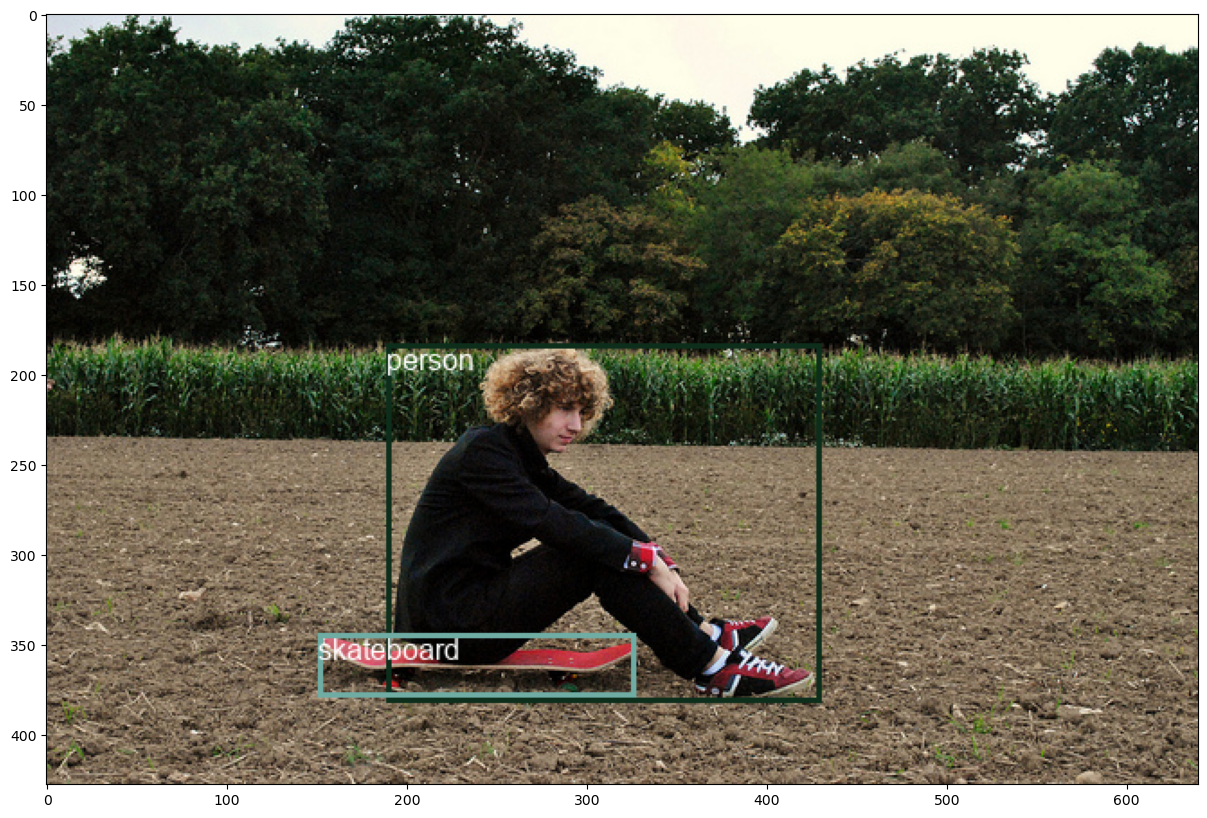

In [7]:
# Define a rescale_bbox helper function to rescale normalized bounding boxes to the original image size:
def rescale_bbox(bb, W, H):
    x, y, w, h = bb
    return [x*W, y*H, w*W, h*H]

# Define the show_img_bbox helper function to show an image with object bounding boxes:
COLORS = np.random.randint(0, 255, size=(80, 3), dtype="uint8")
fnt = ImageFont.truetype('Pillow/Tests/fonts/arial.ttf', 16)
def show_img_bbox(img,targets):
    if torch.is_tensor(img):
        img = to_pil_image(img)
    if torch.is_tensor(targets):
        targets=targets.numpy()[:,1:]
    W, H = img.size
    draw = ImageDraw.Draw(img)
    for tg in targets:
        id_ = int(tg[0])
        bbox  =tg[1:]
        bbox = rescale_bbox(bbox,W,H)
        xc, yc, w, h = bbox
        
        color = [int(c) for c in COLORS[id_]]
        name = coco_names[id_]
        draw.rectangle(((xc-w/2, yc-h/2), (xc+w/2, yc+h/2)), outline=tuple(color), width=3)
        draw.text((xc-w/2, yc-h/2), name, font=fnt, fill=(255,255,255,0))
    plt.imshow(np.array(img))

# 5 Call the show_img_bbox helper function to show a sample image from coco_train:
np.random.seed(2)
rnd_ind = np.random.randint(len(coco_train))
img, labels, path2img = coco_train[rnd_ind] 
print(img.size, labels.shape)

plt.rcParams['figure.figsize'] = (20, 10)
show_img_bbox(img,labels)

(640, 480) (3, 5)


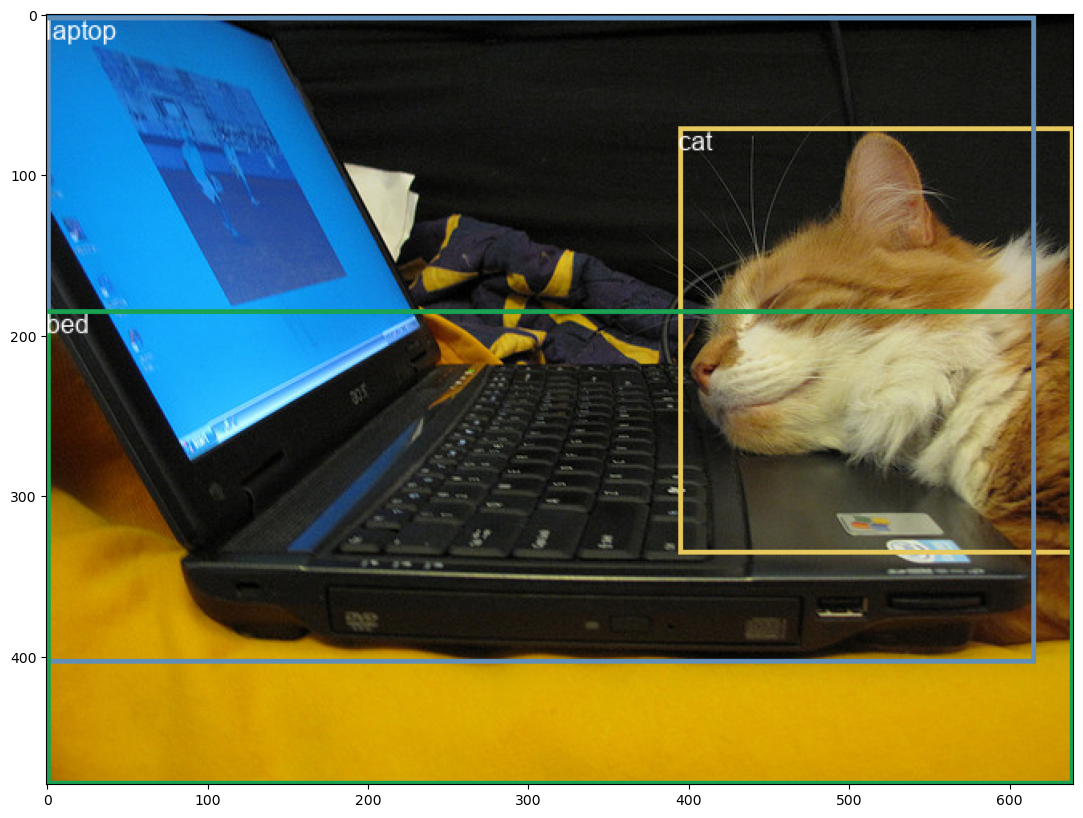

In [8]:
# 6 Call the show_img_bbox helper function to show a sample image from coco_val:
np.random.seed(0)
rnd_ind = np.random.randint(len(coco_val))
img, labels, path2img = coco_val[rnd_ind]
print(img.size, labels.shape)

plt.rcParams['figure.figsize'] = (20, 10)
show_img_bbox(img, labels)

#### **Transforming data**

In this section, we will define a transform function and the parameters to be passed to the CocoDataset class. Let's get started:

In [9]:
# 1 First, we will define a pad_to_square helper function:
def pad_to_square(img, boxes, pad_value=0, normalized_labels=True):
    w, h = img.size
    w_factor, h_factor = (w,h) if normalized_labels else (1, 1)
    
    dim_diff = np.abs(h - w)
    pad1 = dim_diff // 2
    pad2 = dim_diff - pad1
    if h <= w:
        left, top, right, bottom = 0, pad1, 0, pad2
    else:
        left, top, right, bottom = pad1, 0, pad2, 0
    padding = (left, top, right, bottom)

    img_padded = TF.pad(img, padding=padding, fill=pad_value)
    w_padded, h_padded = img_padded.size
    x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
    y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
    x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
    y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)
    x1 += padding[0] # left
    y1 += padding[1] # top
    x2 += padding[2] # right
    y2 += padding[3] # bottom
            
    boxes[:, 1] = ((x1 + x2) / 2) / w_padded
    boxes[:, 2] = ((y1 + y2) / 2) / h_padded
    boxes[:, 3] *= w_factor / w_padded
    boxes[:, 4] *= h_factor / h_padded

    return img_padded, boxes

# 2 Define the hflip helper function to horizontally flip images:
def hflip(image, labels):
    image = TF.hflip(image)
    labels[:, 1] = 1.0 - labels[:, 1]
    return image, labels

# 3 Define the transformer function:
def transformer(image, labels, params):
    if params["pad2square"] is True:
        image, labels = pad_to_square(image, labels)

    image = TF.resize(image,params["target_size"])

    if random.random() < params["p_hflip"]:
        image, labels = hflip(image, labels)

    image = TF.to_tensor(image)
    targets = torch.zeros((len(labels), 6))
    targets[:, 1:] = torch.from_numpy(labels)
    
    return image, targets

image shape: torch.Size([3, 416, 416])
labels shape: torch.Size([2, 6])


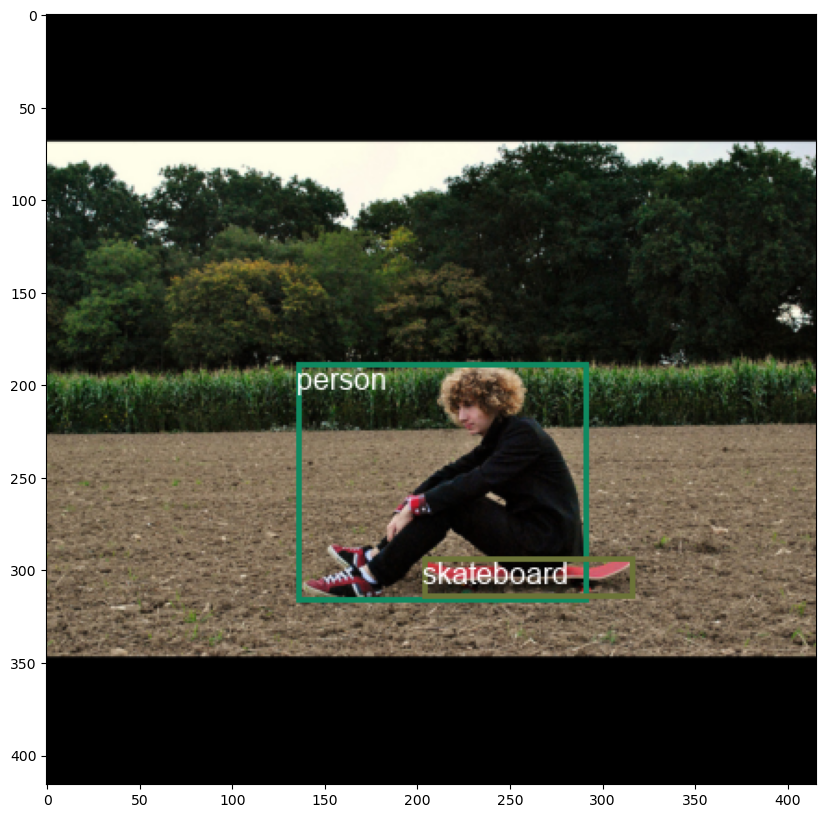

In [10]:
# 4 Now, let's create an object of CocoDataset for training data by passing the transformer function:
trans_params_train={
    "target_size" : (416, 416),
    "pad2square": True,
    "p_hflip" : 1.0,
    "normalized_labels": True,
}
coco_train = CocoDataset(path2trainList, transform=transformer, trans_params=trans_params_train)

# Display a sample image from coco_train:
np.random.seed(2)
rnd_ind=np.random.randint(len(coco_train))
img, targets, path2img = coco_train[rnd_ind] 
print("image shape:", img.shape)
print("labels shape:", targets.shape) 

plt.rcParams['figure.figsize'] = (20, 10)
COLORS = np.random.randint(0, 255, size=(80, 3), dtype="uint8")
show_img_bbox(img, targets)

image shape: torch.Size([3, 416, 416])
labels shape: torch.Size([3, 6])


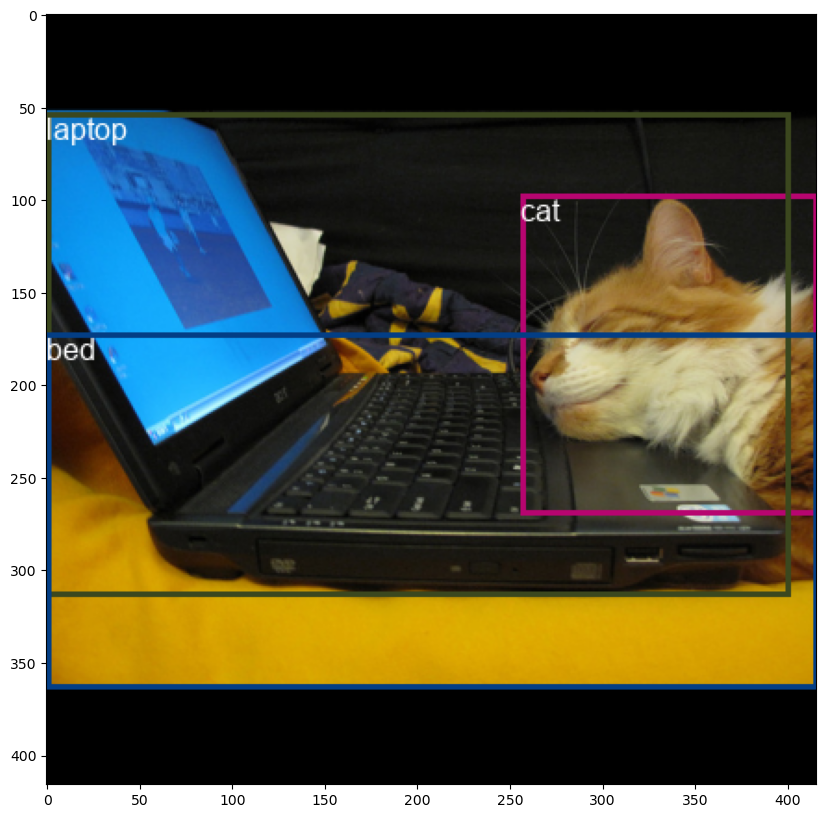

In [11]:
# 5 Similarly, we will define an object of CocoDataset by passing the transformer function to validate the data:
trans_params_val = {
    "target_size" : (416, 416),
    "pad2square": True,
    "p_hflip" : 0.0,
    "normalized_labels": True,
}
coco_val = CocoDataset(path2valList, transform=transformer, trans_params=trans_params_val)

# We will display a sample image from coco_val:

np.random.seed(0)
rnd_ind=np.random.randint(len(coco_val))
img, targets, path2img = coco_val[rnd_ind] 
print("image shape:", img.shape)
print("labels shape:", targets.shape) 

plt.rcParams['figure.figsize'] = (20, 10)
COLORS = np.random.randint(0, 255, size=(80, 3), dtype="uint8")
show_img_bbox(img,targets)


#### **Defining the Dataloaders**

In this section, we will define two dataloaders for training and validation of datasets so we can get mini-batches of data from coco_train and coco_val. Let's get started:

In [12]:
# 1 Define an object of the Dataloader class for the training data:
from torch.utils.data import DataLoader

# Here, collate_fn is defined as follows:
def collate_fn(batch):
    imgs, targets, paths = list(zip(*batch))
    # Remove empty boxes
    targets = [boxes for boxes in targets if boxes is not None]
    # set the sample index 
    for b_i, boxes in enumerate(targets):
        boxes[:, 0] = b_i
    targets = torch.cat(targets, 0)
    imgs = torch.stack([img for img in imgs])
    return imgs, targets, paths

batch_size = 2
train_dl = DataLoader(
    coco_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

# Let's extract a mini-batch from train_dl:
torch.manual_seed(0)
for imgs_batch, tg_batch, path_batch in train_dl:
    break
print(imgs_batch.shape)
print(tg_batch.shape, tg_batch.dtype)

torch.Size([2, 3, 416, 416])
torch.Size([13, 6]) torch.float32


In [13]:
# 2 Define an object of the Dataloader class for the validation data:
val_dl = DataLoader(
        coco_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=collate_fn,
    )

# Let's extract a mini-batch from val_dl:
torch.manual_seed(0)
for imgs_batch,tg_batch,path_batch in val_dl:
    break
print(imgs_batch.shape)
print(tg_batch.shape,tg_batch.dtype)

torch.Size([2, 3, 416, 416])
torch.Size([45, 6]) torch.float32


### **How it works**

In the Creating a custom COCO dataset subsection, we created a PyTorch dataset class for the COCO dataset. First, we imported the required packages. Then, we defined the CocoDataset class. The class started by defining the `__init__` function with three inputs:

* path2listFile: A string stating the location of the text file that contains a list of images 
* transform: A function that defines various transformations, such as resizing and converting into tensors
* trans_params: A Python dictionary that defines transformation parameters such as the target image size
In the `__init__` function, we read the text file and loaded the list of images into `self.path2imgs`. The file contained the full path to the images that will be loaded in the __getitem__ function. Then, we extracted the full path of labels by replacing "images" with "labels" and `".jpg"`, `".png"` with `".txt"` in the path to the images. In the `__len__` function, we returned the length of the dataset.

Next, we defined the `__getitem__` function. This function has one input, which is the index of the image to be loaded. We obtained the full path to the image and labels from `self.path2imgs` and self.path2labels, respectively. Then, we loaded the image as a PIL object. The labels were loaded as a numpy array. Then, we applied the transformations on the image and labels. Finally, we returned the image, labels, and the full path to the image. If no transformation was applied, the returned image and labels were PIL and numpy objects.

In step 2, we created an object of the `CocoDataset` class using the list of training data in "trainvalno5k.txt". We did not pass a transformation function. As we saw, coco_train contains 117264 images to be used for training. Then, we got a sample image from coco_train and printed the size and type of the image and labels. As expected, a `PIL` image and numpy array were returned. Check out the printed labels. The first number in each row was the object ID, while the next four numbers were the normalized bounding box coordinates.

In step 3, similar to step 2, we created an object of the `CocoDataset` class using the list of validation data in `"5k.txt"`. As we saw, there were $5000$ images in `coco_val`. Then, we obtained a sample item from `coco_val` and printed the type and size of the image and labels. You can try to fetch different images by changing the index. As we saw, without any transformation, images have different sizes.

In step 4, we displayed sample images and object bounding boxes from the `coco_train` and `coco_val` datasets. First, we imported the required packages. Then, we loaded COCO object names from the coco.names file into a list. As expected, there were 80 object categories in the file. We will use the names to display the object name on the bounding boxes. 

Next, we defined the rescale_bbox helper function to rescale the normalized bounding boxes to the original image size.  Also, to show the bounding boxes in different colors, we defined `COLORS`, an array of random tuples. 

Then, we defined the `show_img_bbox` helper function with two inputs:

img: Can be a PIL image or a PyTorch tensor that has a shape of `3 x H x W`.
targets: The bounding box coordinates. This can be a numpy array that has a shape of $n \times 5$ or a PyTorch tensor that has a shape of $n \times 6$.
In the function, we check the input data type. If the inputs are PyTorch tensors, we convert them into a PIL image and a numpy array. If img is a tensor, we convert it into a PIL image using the to_pil_image function from torchvision. If the target is a tensor, we convert it into a  numpy array using the `.numpy()` method and skip the first index of the second dimension.

In the rest of the helper function, we looped over the bounding boxes and added them to the image. Notice that we got the bounding box color and name from `COLORS` and names (based on the object index), respectively. The name was put, as a piece of text, on the top left corner of the bounding box. 

Next, we called the `show_img_bbox` helper function to display a sample image and its bounding boxes from `coco_train` and `coco_val`. You can comment out the np.random.seed line to see a different image in each rerun.

In the Transforming the data subsection, we defined the functions required for data transformation. These transformations were required to resize images, augment the data, or convert the data into PyTorch tensors.

We started by defining the `pad_to_square` helper function with four inputs:
* img: A PIL image
* boxes: A numpy array with a shape of $(n, 5)$ that contains n bounding boxes
* `pad_value`: The pixel fill value, which defaults to zero
* normalized_labels: A flag to show whether the bounding boxes were normalized to the range [0, 1]

This function takes a PIL image and pads its borders so it become a square image. In the function, we got the image size and the scaling factors of the labels. Then, we calculated the padding size and divided it into two values: `pad1` and `pad2`. For instance, if the padding size is $100$, then we have `pad1= pad2= 50`. But if the padding size is 101, then we get `pad1=50` and `pad2=51`.

Then, we calculated the padding size on each side of the image. If the height is less than the width, we only need to add pixels to the top and bottom of the image. Otherwise, we add pixels to the left and right of the image.

After padding the image, we adjusted the bounding box coordinates based on the padding size. To this end, we extracted the top-left x1, y1 and bottom-right x2, y2 coordinates of the bounding boxes before padding.

> The boxes array is in [id, xc, yc, w, h] format, where id is the object identifier, xc, yc is the centroid coordinates, and w, h is the width and height of the bounding box.

Then, we adjusted x1, y1, x2, y2 by adding the padding sizes. Next, we calculated the bounding boxes using the adjusted values of x1, y1, x2, y2. Note that we normalized the labels again to the range of [0, 1]. The function returned a square PIL image and its labels as a numpy array.

In step 2, we defined the `hflip` helper function to horizontally flip images and labels. 

In step 3, we defined the transformer function with three inputs:

* `image`: A `PIL` image
* `labels`: Bounding boxes as a `numpy` array that's $(n, 5)$ in size
* `params`: A Python dictionary containing the transformation parameters
The function takes a `PIL` image and its labels and returns the transformed image and labels as PyTorch tensors. In the function, we check for the `pad2square` flag and, if it's True, we call the `pad_to_square` function. Then, the image is resized to $416 \times 416$, which is the standard size for a YOLO-v3 network. Next, we called the `hflip` function to randomly flip the image for data augmentation. Finally, we converted the `PIL` image into a PyTorch tensor using the `to_tensor` function from torchvision. The labels were also converted into a PyTorch tensor of size $n \times 6$. The extra dimension will be used to index images in a mini-batch.

In step 4, we redefined `coco_train`; however, this time, we passed transformer and `trans_params_train` to the CocoDataset class. To force the horizontal flip, we set the `p_hflip` probability to 1.0.  In practice, we usually set the probability to $0.5$. You can see the effect of the transformations on the sample image. The image has been zero-padded from the top and bottom, resized to $416 \times 416$, and horizontally flipped.

Similarly, in step 5, we redefined coco_val. We did not need data augmentation for the validation data, so we set the probability of `p_hflip` to $0.0$.  Check out the transformed sample size. It has been zero-padded from the top and bottom and resized to $416 \times 416$ but not flipped.

In Defining the Dataloaders subsection, we defined two objects of the `Dataloader` class, `train_dl` and `val_dl`, for the training and validation datasets, respectively. We also defined the `collate_fn` function to process a mini-batch and return  PyTorch tensors. The function was given as an argument to the `Dataloader` class so that the process happens on the fly. In the function, we grouped the images, targets, and paths in the mini-batch using `zip(*iterateble)`. Then, we removed any empty bounding boxes in the targets. Next, we set the sample index in the mini-batch. Finally, we concatenated the images and targets as PyTorch tensors. To see how this works, we extracted a mini-batch from `train_dl` and `val_dl` and printed the shape of the returned tensors. Notice that the batch size was set to $16$ in `train_dl`, whereas it was set to $32$ in `val_dl`. Also, there are $87$ bounding boxes in the mini-batch of `train_dl` but there are 250 in `val_dl`.

## **Creating a YOLO-v3 model**

The **YOLO-v3 network is built of convolutional layers with stride $2$, skip connections, and up-sampling layers**. **There are no pooling layers**. The network receives an image whose size is $416 \times 416$ as input and provides $3$ YOLO outputs, as shown in the following figure:

![](yolo_v3.png)

The network down-samples the input image by a factor of $32$ to a feature map of size $13 \times 13$, where `yolo-out1` is provided. To improve the detection performance, the $13 \times 13$ feature map is up-sampled to $26 \times 26$ and $52 \times 52$, where we have `yolo-out2` and `yolo-out3`, respectively. A cell in a feature map predicts three bounding boxes that correspond to three predefined anchors. As a result, the network predicts $13 \times 13 \times 3+26 \times 26 \times 3+52 \times 52 \times 3=10647$ bounding boxes in total.

A bounding box is defined using 85 numbers:

* Four coordinates, `[x, y, w, h]`
* An abjectness score
* `C=80` class predictions corresponding to 80 object categories in the COCO dataset

In this recipe, we will show you how to develop a `YOLO-v3` model using PyTorch.

### **How to do it**

In this recipe, we will define a few helper functions to parse the configuration file, create PyTorch modules, and define the Darknet model.

#### **Parsing the configuration file**

We need to parse the configuration file to be able to build the model. We have provided a myutils.py file that contains a helper function with which you can do this. The configuration file `yolov3.cfg` was downloaded previously in the Creating Datasets: Getting Ready recipe. Let's get started:

In [14]:
# 1 First, we will import the parse_model_config helper function:
from myutils import parse_model_config

# 2 Let's read and print out the config file using the parse_model_config helper function:
path2config="./config/yolov3.cfg"
blocks_list = parse_model_config(path2config)
blocks_list

[{'type': 'net',
  'batch': '64',
  'subdivisions': '16',
  'width': '608',
  'height': '608',
  'channels': '3',
  'momentum': '0.9',
  'decay': '0.0005',
  'angle': '0',
  'saturation': '1.5',
  'exposure': '1.5',
  'hue': '.1',
  'learning_rate': '0.001',
  'burn_in': '1000',
  'max_batches': '500200',
  'policy': 'steps',
  'steps': '400000,450000',
  'scales': '.1,.1'},
 {'type': 'convolutional',
  'batch_normalize': '1',
  'filters': '32',
  'size': '3',
  'stride': '1',
  'pad': '1',
  'activation': 'leaky'},
 {'type': 'convolutional',
  'batch_normalize': '1',
  'filters': '64',
  'size': '3',
  'stride': '2',
  'pad': '1',
  'activation': 'leaky'},
 {'type': 'convolutional',
  'batch_normalize': '1',
  'filters': '32',
  'size': '1',
  'stride': '1',
  'pad': '1',
  'activation': 'leaky'},
 {'type': 'convolutional',
  'batch_normalize': '1',
  'filters': '64',
  'size': '3',
  'stride': '1',
  'pad': '1',
  'activation': 'leaky'},
 {'type': 'shortcut', 'from': '-3', 'activatio

#### **Creating PyTorch modules**

In this section, we will create PyTorch modules based on our parsed configuration file. We have provided the `myutils.py` file, which contains a helper function you can use to create PyTorch modules for the YOLOv3 network. Let's get started:

In [15]:
# 1 First, we will import the create_layers helper function to convert blocks_list into PyTorch modules:
from myutils import create_layers

# 2 Now, let's call the create_layers function and get a list of PyTorch modules:
hy_pa, m_l = create_layers(blocks_list)
print(hy_pa)
print(m_l)

{'type': 'net', 'batch': '64', 'subdivisions': '16', 'width': '608', 'height': '608', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '500200', 'policy': 'steps', 'steps': '400000,450000', 'scales': '.1,.1'}
ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_1): LeakyReLU(negative_slope=0.1)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batch_norm_2): BatchNorm2d(

#### **Defining the Darknet model**

In [16]:
from torch import nn
# 1 Now, let's learn how to define the Darknet class:
# We start by defining the __init__ function:
class Darknet(nn.Module):
    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.blocks_list = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_layers(self.blocks_list)
        self.img_size = img_size
        
    # 2 Next, we define the forward function of the Darknet class:
    def forward(self, x):
        img_dim = x.shape[2]
        layer_outputs, yolo_outputs = [], []
        
        for block, module in zip(self.blocks_list[1:], self.module_list):
            if block["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif block["type"] == "shortcut":
                layer_ind = int(block["from"])
                x = layer_outputs[-1] + layer_outputs[layer_ind]
            elif block["type"] == "yolo":
                x= module[0](x)
                yolo_outputs.append(x)
            elif block["type"] == "route":
                x = torch.cat([layer_outputs[int(l_i)] for l_i in block["layers"].split(",")], 1)
            layer_outputs.append(x)
        yolo_out_cat = torch.cat(yolo_outputs, 1)
        return yolo_out_cat, yolo_outputs
        
# 3 Let's create an object of the Darknet class:
model = Darknet(path2config).to(device)
print(model)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [17]:
# 4 Next, let's test the model using a dummy input:
dummy_img = torch.rand(1, 3, 416, 416).to(device)
with torch.no_grad():
    dummy_out_cat, dummy_out=model.forward(dummy_img)
    print(dummy_out_cat.shape)
    print(dummy_out[0].shape, dummy_out[1].shape, dummy_out[2].shape)

torch.Size([1, 10647, 85])
torch.Size([1, 507, 85]) torch.Size([1, 2028, 85]) torch.Size([1, 8112, 85])


### **How it works**

In the Parsing the configuration file subsection, we defined a helper function to parse the YOLO-v3 configuration file. For brevity, we defined the helper function in `myutils.py`, which is provided as part of this book. The input to the function is `path2file`, a string, that can be located at `"./config/yolov3.cfg"`.

The function parses the configuration file and returns the layers as a list of dictionaries. In the helper function, we split the file into lines using `.split("\n")`.  Then, we removed any empty lines and comments. Next, we removed white spaces leading or tailoring a line using `rstrip()` and `lstrip()` respectively. Next, we defined an empty list called `layers_list` and looped over the lines. If a line starts with `"["`, a new layer is created. For a new layer, we append a dictionary to `layers_list`.  The dictionary has a `"type"` key, which shows the type of the layer. The first layer's type is `"net"`, which defines the hyperparameters of the network. We verify that the `"height"` and `"width"` parameters are set to `"416"`. If a line does not start with `"["`, it is added to the current dictionary as an attribute of the layer.

In the Creating PyTorch modules subsection, we defined a helper function called create_layers to create PyTorch modules corresponding to the layers. For brevity, we defined the helper function in the `myutils.py` file and imported the helper function from `myutils.py`. Nevertheless, we will explain the helper function.

The input to the function is `blocks_list`, which provides a list of layers that were parsed from the configuration file in the Parsing the configuration file subsection.

In the function, we extracted the hyperparameters from the first block. Next, we created `channels_list` to hold the number of input channels for each layer. For the first layer, **the number of input channels is $3$** (the same as the image channels). Next, we created an object of the `nn.ModuleList` class to hold the submodules. Then, we created a loop to go over the list of the blocks.

> As a reminder, the first block contains the model's hyperparameters.

Next, we created an object of the `nn.Sequential` class to add multiple layers to a module. For instance, for  "convolutional" blocks, we sequentially added `nn.Conv2d`, `nn.BatchNorm2d`, and `nn.LeakyReLU` using the `add_module` method. 

Next, in the main loop, we checked for up-sampling blocks. Up-sampling layers were used in `YOLO-v3` to **up-sample the feature maps to a higher resolution so that they could be concatenated with earlier layers**. The `nn.Upsample` module takes the `stride=2` parameter and **up-samples the feature maps by a factor of $2$**. We used the default `mode="nearest"` for up-sampling.

Next, in the loop, we checked for shortcut blocks. They are used to create skip connections. 

> A shortcut block in the configuration file was defined as follows:
```py
[shortcut]
from=-3
activation=linear
```
> Here, `from=-3` means that the **skip connection comes from the third layer backward from the shortcut block**.

The number of filters was set to that of the skip connection stored in `channels_list`.
Next, in the loop, we checked for route blocks. 

> The route blocks were defined with one or two arguments in the configuration file.

If defined with one argument, as shown in the following snippet, the feature maps of the fourth layer, backward from the route layer, were returned:
```python
[route]
layers = -4
```

If defined with two arguments, they were used to concatenate feature maps from multiple layers. For example, in the following snippet, the feature maps from the previous layer and the $61^{st}$ layer were concatenated along the depth dimension:

```python
[route]
layers = -1, 61
```

Note that the actual concatenation will happen in the forward function of the network class. Here, we only summed the number of filters in the route layers.

Next in the loop, we checked for yolo blocks. There were three yolo blocks that corresponded to three detection outputs in the configuration file. Let's look at the first yolo block of the configuration file:

```python
[yolo]
mask = 6,7,8
anchors = 10,13, 16,30, 33,23, 30,61, 62,45, 59,119, 116,90, 156,198, 373,326
classes=80
num=9
jitter=.3
ignore_thresh = .5
truth_thresh = 1
random=1
```

In our code, we extracted the anchors attribute and grouped the blocks as a list of nine tuples corresponding to nine anchors in YOLO-v3. The first tuple is $(10, 13)$ at index 0, while the last tuple is $(373, 326)$ at index 8.

> There are three anchors per YOLO output.

Next, we extracted the mask attribute as a list of three values. Since there are three anchors per yolo block, the mask attribute represents the indices of those three anchors. For instance, the last three anchors indexed at $6, 7, 8$ belong to the first yolo output. Thus, the anchors for the first yolo output were as follows:

```py
anchors =  [(116,90), (156,198), (373,326)]
```

Then, we extracted the number of object categories and the image size, which are $80$ and $416$, respectively. At this point, we checked all the layer types in the main loop of the create_layers function. Each layer type resulted in a PyTorch module that was appended to `module_list`. Then, we returned `module_list` and hyperparams. 

Next, we defined the EmptyLayer class, which does nothing in a skip or shortcut connection. Then, we defined the YOLOLayer class. First, we defined the bulk of the YOLOLayer class and added the functions one by one for code readability. Then, we defined the `__init__` function and initialized the variables. The function has three inputs:

* anchors, which is a list of three tuples
* num_classes, which is 80 categories for the COCO-2107 dataset
* img_dim, which is an image dimension of 416

Next in the class, we defined the forward function with one input. The input to the function is a feature map with a shape of `[batch_size, 3 x 85, 13, 13]` for the first yolo layer. The function started by extracting the batch size and grid size. For the first yolo layer, the grid size is $13$. Next, we reshaped the input feature map to `[batch_size, 3, 13, 13, 85]`.

Next, we applied the sigmoid function to the abjectness score and class predictions. As we mentioned previously, the network predicts 85 values per bounding box: four values as `[x, y, w, h]`, an abjectness score, and 80 class predictions. Then, we computed the grid offsets using the `compute_grid_offsets` helper function. We defined this helper function in step 4. Next, we transformed the predictions into bounding boxes using the transform_outputs helper function, which was defined in step 5.

Then, the bounding box predictions were concatenated with the abjectness scores and class predictions and returned as the output of the function.

Next, we defined the compute_grid_offsets helper function. The helper function is a method of the YOLOLayer class and has three inputs:

* `self`: This refers to the YOLOLayer class.
* `grid_size`: The grid size, which can be 13, 26, 52.
* The cuda flag: True or False value depending on the availability of CUDA/GPU devices.

For a given grid_size=13, the function creates a grid of $13 \times 13$ on the $x$ and $y$ dimensions. It also scales the anchors by `self.stride=32`.

In step 5, we defined the transform_outputs helper function. This function is a method of the YOLOLayer class and has two inputs:

* self: Refers to the YOLOLayer class
* predictions: A tensor of shape `(batch_size, 3, grid_size, grid_size, 85)`

This function applied sigmoid non-linearity, added grid offsets to the $x$, $y$ coordinates, and scaled them to $w, h$ with the scaled anchors. The output of this helper function was the scaled bounding box predictions.

In step 2, we called the create_layers function to make sure it works properly. The input to this function is the `blocks_list` that we obtained by parsing the configuration file. The function returned the hyperparameters and a list of $106$ PyTorch modules corresponding to the parsed layers. Check out the yolo layers at $82, 94$, and $106$. 

In the Defining the Darknet model subsection, we defined the Darknet  class, which is the complete detection network. First, we defined the `__init__`  function with three inputs:

* `self`: Refers to the Darknet class
* `config_path`: The location of the config file
* `img_size`: The image dimension size, whose default is 416
In the `__init__` function, we called the `parse_model_config` and `create_layers` helper functions to get a list of blocks and PyTorch modules. These are the building blocks of the YOLO-v3 network.

In step 2, we defined the forward function with two inputs:

* `self`: Refers to the Darknet class
* $x$: A tensor of shape (`batch_size`, $3$, $416$, $416$)
In the forward function, we initially defined two lists to keep track of the outputs of each layer and those of the yolo layers.  Then, we looped over the list of blocks and modules.

> As a reminder, the first block belongs to the hyperparameters. As such, in `self.blocks_list[1:]`, the index starts at 1.

In the loop, if we encountered convolutional blocks, we passed the input tensor to the module and appended the output to the `layer_outputs` list. Then, if we encountered shortcut blocks, we extracted the shortcut layer index and added the output of the shortcut layer to that of the previous layer. The result was then appended to the `layer_outputs` list. Next, if we encountered yolo layers, we appended the module output to both the `layer_outputs` and `yolo_outputs` lists. Lastly, if we encountered route layers, we extracted the route layer indices and concatenated the outputs of the route layers. Eventually, we concatenated the tensors of the `yolo_outputs` list as a `yolo_out_cat` tensor and returned both outputs.

In step 3, we created an object of the Darknet class called model and printed it. As we saw, the complete YOLO-v3 architecture was created. We checked the model architecture when it was printed. It should have $106$ layers with three YOLOLayer modules at indices $82, 94$, and $106$.

> There are a total of $106$ layers in the YOLO-v3 architecture. Layers $82, 94, 106$ are the three yolo outputs.

In step 4, to check the architecture and verify our code, we passed a dummy image to the model and obtained the output. As a reminder, there were three yolo outputs of shape $(1, 507, 85)$, $(1, 2028, 85)$, and $(1, 8112, 85)$. The final output was the concatenation of these three layers in dimension 1. The output size was $(1, 10647, 85)$ since $507+2028+8112=10647$. In other words, for every input image, YOLO-v3 predicts 10647 bounding boxes.

## **Defining the loss function**

In this recipe, we will define a loss function for the YOLO-v3 architecture. To get an insight into of the YOLO-v3 loss, recall that the model output comprises the following elements:

* `[x, y, w, h]` of bounding boxes
* An objectness score
* Class predictions for $80$ object categories
Thus, the `YOLO-v3` loss function is composed of the following:

$loss = loss_x + loss_y + loss_w + loss_h + loss_{obj} + loss_{cls}$

Here, we have the following

* $loss_x, loss_y, loss_w, loss_h$ are the **mean squared error** of $x, y, w, h$
* $loss_{obj}$ is the **binary cross-entropy loss of the objectness score**
* $loss_{cls}$ is the **binary cross-entropy loss of class predictions**
In this recipe, you will learn how to implement a combined loss function for the `YOLO-v3` algorithm.

### **How to do it**

In [18]:
# 1 Define the get_loss_batch helper function to compute the loss value for a mini-batch
def get_loss_batch(output, targets, params_loss, opt=None):
    ignore_thres = params_loss["ignore_thres"]
    scaled_anchors = params_loss["scaled_anchors"]
    mse_loss = params_loss["mse_loss"]
    bce_loss = params_loss["bce_loss"]

    num_yolos=params_loss["num_yolos"]
    num_anchors= params_loss["num_anchors"]
    obj_scale= params_loss["obj_scale"]
    noobj_scale= params_loss["noobj_scale"]
    # continue by looping over the model outputs:
    loss=0.0
    for yolo_ind in range(num_yolos):
        yolo_out=output[yolo_ind]
        batch_size, num_bbxs, _=yolo_out.shape
        gz_2=num_bbxs/num_anchors
        grid_size=int(np.sqrt(gz_2))
        yolo_out=yolo_out.view(batch_size,num_anchors,grid_size,grid_size,-1)
        # continue by extracting the predicted bounding boxes:
        pred_boxes=yolo_out[:,:,:,:,:4]
        x,y,w,h= transform_bbox(pred_boxes, scaled_anchors[yolo_ind])
        pred_conf=yolo_out[:,:,:,:,4]
        pred_cls_prob=yolo_out[:,:,:,:,5:]
        # call he get_yolo_targets helper function
        yolo_targets = get_yolo_targets({
            "pred_cls_prob": pred_cls_prob,
            "pred_boxes":pred_boxes,    
            "targets": targets,    
            "anchors": scaled_anchors[yolo_ind],    
            "ignore_thres": ignore_thres,
        }) 
    obj_mask=yolo_targets["obj_mask"]        
    noobj_mask=yolo_targets["noobj_mask"]            
    tx=yolo_targets["tx"]                
    ty=yolo_targets["ty"]                    
    tw=yolo_targets["tw"]                        
    th=yolo_targets["th"]                            
    tcls=yolo_targets["tcls"]                                
    t_conf=yolo_targets["t_conf"]
    loss_x = mse_loss(x[obj_mask], tx[obj_mask])
    loss_y = mse_loss(y[obj_mask], ty[obj_mask])
    loss_w = mse_loss(w[obj_mask], tw[obj_mask])
    loss_h = mse_loss(h[obj_mask], th[obj_mask])

    loss_conf_obj = bce_loss(pred_conf[obj_mask], t_conf[obj_mask])
    loss_conf_noobj = bce_loss(pred_conf[noobj_mask], t_conf[noobj_mask])
    loss_conf = obj_scale * loss_conf_obj + noobj_scale * loss_conf_noobj
    loss_cls = bce_loss(pred_cls_prob[obj_mask], tcls[obj_mask])
    loss += loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item()

# transform_bbox function
def transform_bbox(bbox, anchors):
    x=bbox[:, :, :, :,0]
    y=bbox[:, :, :, :,1]
    w=bbox[:, :, :, :,2]
    h=bbox[:, :, :, :,3]
    anchor_w = anchors[:, 0].view((1, 3, 1, 1))
    anchor_h = anchors[:, 1].view((1, 3, 1, 1))       
    
    x=x-x.floor()
    y=y-y.floor()
    w= torch.log(w / anchor_w + 1e-16)
    h= torch.log(h / anchor_h + 1e-16)
    return x, y, w, h

# 2 In step 1, we called the get_yolo_targets helper function, which is defined as follows:
def get_yolo_targets(params):
    pred_boxes=params["pred_boxes"]
    pred_cls_prob=params["pred_cls_prob"]
    target=params["targets"]
    anchors=params["anchors"] 
    ignore_thres=params["ignore_thres"] 

    batch_size = pred_boxes.size(0)
    num_anchors = pred_boxes.size(1)
    grid_size = pred_boxes.size(2)
    num_cls = pred_cls_prob.size(-1)
    # continue by initializing the output tensors:
    sizeT = batch_size, num_anchors, grid_size, grid_size
    obj_mask = torch.zeros(sizeT,device=device, dtype=torch.bool)
    noobj_mask = torch.ones(sizeT,device=device, dtype=torch.bool)
    tx = torch.zeros(sizeT, device=device, dtype=torch.float32)
    ty= torch.zeros(sizeT, device=device, dtype=torch.float32)
    tw= torch.zeros(sizeT, device=device, dtype=torch.float32)
    th= torch.zeros(sizeT, device=device, dtype=torch.float32)
    sizeT=batch_size, num_anchors, grid_size, grid_size, num_cls
    tcls= torch.zeros(sizeT, device=device, dtype=torch.float32)
    # continues by scaling and extracting the target bounding boxes:
    target_bboxes = target[:, 2:] * grid_size
    t_xy = target_bboxes[:, :2]
    t_wh = target_bboxes[:, 2:]
    t_x, t_y = t_xy.t()
    t_w, t_h = t_wh.t()
    grid_i, grid_j = t_xy.long().t()
    # continues by choosing the anchor that has the highest IOU with the targets:
    iou_with_anchors = [get_iou_WH(anchor, t_wh) for anchor in anchors]
    iou_with_anchors = torch.stack(iou_with_anchors)
    best_iou_wa, best_anchor_ind = iou_with_anchors.max(0)
    # continues by setting the object mask tensors:
    batch_inds, target_labels = target[:, :2].long().t()
    obj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 1
    noobj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 0

    for ind, iou_wa in enumerate(iou_with_anchors.t()):
        noobj_mask[batch_inds[ind], iou_wa > ignore_thres, grid_j[ind], grid_i[ind]] = 0
    tx[batch_inds, best_anchor_ind, grid_j, grid_i] = t_x - t_x.floor()
    ty[batch_inds, best_anchor_ind, grid_j, grid_i] = t_y - t_y.floor()
    # continues by setting w and h:
    anchor_w = anchors[best_anchor_ind][:, 0]
    tw[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_w / anchor_w + 1e-16)
    
    anchor_h = anchors[best_anchor_ind][:, 1]
    th[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_h / anchor_h + 1e-16)
    # continues by setting target classes:
    tcls[batch_inds, best_anchor_ind, grid_j, grid_i, target_labels] = 1
    # returns the output as a Python dictionary:
    output={
        "obj_mask" : obj_mask,
        "noobj_mask" : noobj_mask,
        "tx": tx,
        "ty": ty,
        "tw": tw,
        "th": th,
        "tcls": tcls,
        "t_conf": obj_mask.float(),
    }
    return output

# 3 Next, we define the get_iou_WH helper function:
def get_iou_WH(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

### **How it works**

In step 1, we defined the `get_loss_batch` helper function. The function inputs were as follows:

* `output`: A list of three tensors corresponding to the YOLO-v3 outputs.
* `targets`: The ground truth, a tensor of shape $n \times 6$, where $n$ is **the total number of bounding boxes in the batch**.
* `params_loss`: A Python dict, which contains the loss parameters.
* `opt`:  An object of the optimizer class. The default value is None.
As you can see, we broke down the helper function into multiple snippets for better code readability. Initially, we extracted the parameters from the `params_loss` dictionary. Then, we created a loop of `num_yolos=3` iterations. In each iteration, we extracted the YOLO output `(yolo_out)`, the number of bounding boxes `(num_bboxs)`, and the grid size `(gird_size)`. 

> As a reminder, there were three YOLO outputs with $507, 2028, 8112$ bounding boxes in each output, respectively. Also, the grid sizes were $13, 26, 52$, respectively.

Then, we reshaped `yolo_out` to (`batch_size`, 3, `grid_size`, `grid_size`, $85$) in each iteration. Here, we had 3*13*13=507, 3*26*26=2028,  and $3 \times 52 \times 52=8112$. From the reshaped tensor, we got the predicted bounding boxes (`pred_boxes`), objectness score (`pred_conf`), and the class probabilities (`pred_cls_prob`). We also transformed the predicted bounding boxes using the `transform_bbox` helper function. We defined the `transform_bbox` helper function in step 2.

Next, we passed the params_target dictionary to the `get_yolo_targets` helper function to obtain yolo_targets. We defined the `get_yolo_targets` function in step 3. The output of the `get_yolo_targets` function was a dictionary that contained the variables we needed to compute the loss value.

Next, we calculated the mean-squared error (mse_loss) between the predicted and the target coordinates of the bounding boxes (`loss_x`, `loss_y`, `loss_w`, `loss_h`). Then, we calculated the binary cross-entropy loss (`bce_loss`) between the predicted and target objectness scores. We also calculated the `bce_loss` for the predicted class probabilities and target labels. Finally, all the calculated loss values were summed together. This was repeated three times and the loss value of each iteration was added to that of the previous iteration.

If the optimization object, `opt`, has a value, we compute the gradients and perform the optimization step; otherwise, we return the total loss.

> The optimizer will be used during training to update the model parameters.

In step 2, we defined the transform_bbox helper function. The inputs to the helper function were as follows:

bbox: A tensor of shape (`batch_size`, $3$, `grid_size`, `grid_size`, $4$) that contains the predicted bounding boxes.
anchors: A tensor of shape (3, 2) that contains the scaled widths and heights of the three anchors for each YOLO output. For example, the width and height of the three anchors in the first YOLO output, are [[116, 90], [156, 198], [373, 326]] and their scaled values are `[[ 3.6250, 2.8125], [ 4.8750, 6.1875], [11.6562, 10.1875]]`. Here, the **scale factor** is $32$.

This function takes the predicted bounding boxes and transforms them so that they're compatible with the target values. This transformation is the reverse of the transform_outputs function from the YOLOLayer class that we defined in the Creating the YOLOv3 model recipe.

In the function, we extracted the $x, y, w, h$ tensors from `bbox`. Then, we sliced the two columns of the anchors tensor and reshaped them into tensors of shape $(1, 3, 1, 1)$ using the `.view()` method. Next, we transformed the values and returned a list of four tensors corresponding to $x, y, w, h$. 

In step 3, we defined the `get_yolo_targets` helper function. The input to the function was a Python dictionary with the following keys:

* `pred_boxes`: A tensor of shape `(batch_size, 3, grid_size, grid_size, 4)` that contains the predicted bounding boxes.
* `pred_cls_prob`: A tensor of shape `(batch_size, 3, grid_size, grid_size, 80)` that contains the predicted class probabilities.
* `targets`: A tensor of shape $(n, 6)$, where $n$ is the number of bounding boxes in a batch, containing the ground truth bounding boxes and labels.
* `anchors`: A tensor of shape $(2, 3)$ that contains the scaled width and height of the three anchors.
* `ignore_thres`: A scalar float value set to $0.5$, which is used as the threshold value.

In the function, we extracted the keys and initialized the output tensors. The `obj_mask` and `noobj_mask` tensors will be used later to filter the coordinates of the bounding boxes when calculating the loss function. Then, we sliced the target bounding boxes from the target tensor and scaled by the grid size. This was due to the fact that the original target bounding boxes were normalized. The new tensor, `target_bboxes`, of shape $(n, 4)$ contains the scaled coordinates of the bounding boxes $[x, y, w, h]$. Next, we extracted $x, y, w, h$ into four individual tensors of $n$ items.

> The `.t()` method is used to transpose a tensor. For example, if A is a $2 \times 3$ tensor, `A.t()` will be a $3 \times 2$ tensor.

Next, we calculated the intersection over union (IoU) of a target and the three anchors using the `get_iou_WH` helper function. Then, we found the anchor that has the highest IOU with a target. The `get_iou_WH` helper function was defined in step 4.

> The `.long()` method is used to convert float values into integer values.

Next, we extracted the batch index and object labels from the target tensor. The batch_inds variable holds the indices of images in the batch, which range from $0$ to `batch_size-1`.  The `target_labels` variable holds the `object classes`, which range from $0$ to $79$ since the total number of object classes is $80$. Next, we updated the `obj_mask, noobj_mask, tx, ty, tw, th`, and `tcls` tensors.

> The `tx` and `ty` tensors were updated so that they could hold values in the range of $(0, 1)$.

In step 4, we defined the `get_iou_WH` helper function. The inputs to the helper function are as follows:

* `wh1`: A tensor of shape $(1, 2)$, which contains the width and height of an anchor
* `wh2`: A tensor of shape $(n, 2)$, which contains the width and height of the target bounding boxes
Here, we transposed wh2 into a tensor of shape $(2, n)$. Then, we calculated the intersection and union of the targets with the anchor and returned IOU values.

## **Training the model**

So far, we've created dataloaders and defined the model and the loss function. In this recipe, we will develop the code to train the model. The training process will follow the **standard stochastic gradient descent (SGD)**process. We will train the model on the training data and evaluate it on the validation data. Due to the large size of the COCO dataset and our deep model of the YOLO-v3 architecture, training will be very slow, even when using a GPU. You may need to train the model for up to a week to get good performance.

### **How to do it**

We will define a few helper functions, set the necessary hyperparameters, and train the model. Let's get started:

In [19]:
# 1 Define the loss_epoch helper function to compute the loss function for each epoch:
def loss_epoch(model, params_loss, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)
    running_metrics = {}
    
    for xb, yb, _ in dataset_dl:
        yb = yb.to(device)
        _, output = model(xb.to(device))
        loss_b = get_loss_batch(output, yb, params_loss, opt)
        running_loss += loss_b
        if sanity_check is True:
            break 
    loss = running_loss/float(len_data)
    return loss

# 2 Define the train_val helper function to train the model:
import copy
def train_val(model, params):
    num_epochs = params["num_epochs"]
    params_loss = params["params_loss"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    loss_history = {
        "train": [],
        "val": [],
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr)) 
        model.train()
        train_loss = loss_epoch(model,params_loss, train_dl, sanity_check,opt)
        loss_history["train"].append(train_loss)
        print("train loss: %.6f" %(train_loss))
        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, params_loss,val_dl, sanity_check)
        loss_history["val"].append(val_loss)
        print("val loss: %.6f" %(val_loss))
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
        print("-"*10) 
    model.load_state_dict(best_model_wts)
    return model, loss_history

# Here, the get_lr helper function is defined as follows:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# 3Before calling the train_val function, let's define the optimizer:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20, verbose=1)

path2models= "../models/"
if not os.path.exists(path2models): os.mkdir(path2models)
        
scaled_anchors=[model.module_list[82][0].scaled_anchors,
                model.module_list[94][0].scaled_anchors,
                model.module_list[106][0].scaled_anchors]

# Then, we will set the loss parameters:
mse_loss = nn.MSELoss(reduction="sum")
bce_loss = nn.BCELoss(reduction="sum")
params_loss={
    "scaled_anchors" : scaled_anchors,
    "ignore_thres": 0.5,
    "mse_loss": mse_loss,
    "bce_loss": bce_loss,
    "num_yolos": 3,
    "num_anchors": 3,
    "obj_scale": 1,
    "noobj_scale": 100,
} 

# Next, we will set the training parameters and call the train_val function:
params_train={
    "num_epochs": 20,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models + "weights.pt",
}
model, loss_hist = train_val(model, params_train)

"""
Depending on your computer's capability, you may get an out-of-memory
error while running the preceding snippet.

If you get an out of memory error on your computer, try to reduce the
batch size and restart the notebook.
"""

Epoch 0/19, current lr=0.001


KeyboardInterrupt: 

### **How it works**

In step 1, we defined the loss_epoch helper function to compute the loss value in an epoch.

The inputs to this function are as follows:

* `model`: An object of the model class
* `param_loss`: A Python dictionary that holds the parameters of the loss function 
* `dataset_dl`: An object of the dataloader class
* `sanity_check`: A flag with a default value of `False` to break the loop after one batch
* `opt`: An object of the optimization class with a default value of `None`

In this function, we extracted batches of data and target values using the dataloader. Then, we fed the data to the model and obtained the second output.

> The model returns two outputs. The first output is a tensor of shape `(batch_size, 10647, 85)`, which is the concatenation of three YOLO outputs. The second output is a list of three tensors that correspond to the three YOLO outputs.

Next, we computed the loss value for each batch using the `get_loss_batch` function, which was defined in the Defining the loss function recipe. If the `sanity_check` flag is `True`, we break the loop; otherwise, we continue the loop and return the average loss value. 

In step 2, we defined the `train_val` helper function. The inputs to the function are as follows:

* `model`: An object of the model class
* `params`: A Python dictionary that contains the training parameters

In this function, we extracted the `params` keys and initialized a few variables. Then, the training loop started. In each iteration of the loop, we trained the model for one epoch on the training data and computed the training loss for each epoch using the `loss_epoch` helper function. Next, we evaluated the model on the validation data and computed the validation loss. Notice that, for the validation data, we did not pass the opt argument to the `loss_epoch` function. If the validation loss improved in an iteration, we stored a copy of the model weights. We also used the learning scheduler to monitor the loss and reduce the learning rate in the case of plateaus. In the end, the trained model and the loss history were returned.
We also defined the `get_lr` helper function, which is a simple function that returns the learning rate in each iteration of the training loop.

In step 3, we got ready to train the model. First, we defined the optimizer and learning rate schedule. Then, we defined the loss and training parameters. Next, we called the `train_val` function. Due to the large COCO dataset and the YOLO-v3 model, the training will be very slow, even using a GPU. You'll need to train the model for up to a week. It is better to set the `sanity_check` flag to `True` first to quickly run through the training loop in a short amount of time and fix any possible errors. Then, you can set the flag back to `False` and train the model using the complete dataset.

## **Deploying the model**

Now that training is complete, it is time to deploy the model. To deploy the model, we need to define the model class, as described in the Creating the YOLOv3 model recipe. Then, we need to load the trained weights into the model and deploy it on the validation dataset. Let's learn how to do this.

In this recipe, you will learn how to load weights into the model, deploy it on a sample image, and display the results.

### **How to do it**

We will load weights and deploy the model on a sample image. Let's get started:

In [ ]:
# Load trained weights into the model:
path2weights="../models/weights.pt"
model.load_state_dict(torch.load(path2weights))

# 2 Get a sample image from the validation dataset:
img,tg,_=coco_val[4]
print(img.shape)
print(tg.shape)

NameError: name 'model' is not defined

In [ ]:
# 3 Let's display the image and its bounding boxes:
show_img_bbox(img, tg)

In [ ]:
# 4 Now, let's feed the image to the model to get the output:
model.eval()
with torch.no_grad():
    out, _ =model(img.unsqueeze(0).to(device))
print(out.shape)

In [ ]:
# 8 xywh2xyxy is defined as follows:
def xywh2xyxy(xywh):
    xyxy = xywh.new(xywh.shape)
    xyxy[..., 0] = xywh[..., 0] - xywh[..., 2] / 2.0
    xyxy[..., 1] = xywh[..., 1] - xywh[..., 3] / 2.0
    xyxy[..., 2] = xywh[..., 0] + xywh[..., 2] / 2.0
    xyxy[..., 3] = xywh[..., 1] + xywh[..., 3] / 2.0
    return xyxy

# 9 xyxyh2xywh is defined as follows:
def xyxyh2xywh(xyxy, img_size=416):
    xywh = torch.zeros(xyxy.shape[0],6)
    xywh[:,2] = (xyxy[:, 0] + xyxy[:, 2]) / 2./  img_size
    xywh[:,3] = (xyxy[:, 1] + xyxy[:, 3]) / 2. / img_size
    xywh[:,5] = (xyxy[:, 2] - xyxy[:, 0]) / img_size 
    xywh[:,4] = (xyxy[:, 3] - xyxy[:, 1]) / img_size
    xywh[:,1]= xyxy[:,6]    
    return xywh

# 10 bbox_iou is defined as follows:
def bbox_iou(box1, box2):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) \
                    * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    b1_area = (b1_x2 - b1_x1 + 1.0) * (b1_y2 - b1_y1 + 1.0)
    b2_area = (b2_x2 - b2_x1 + 1.0) * (b2_y2 - b2_y1 + 1.0)
    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
    return iou

# 7 The NonMaxSuppression function is defined as follows:
def NonMaxSuppression(bbox_pred, obj_threshold=0.5, nms_thres=0.5):
    bbox_pred[..., :4] = xywh2xyxy(bbox_pred[..., :4])
    output = [None] * len(bbox_pred)
    for ind, bb_pr in enumerate(bbox_pred):
        bb_pr = bb_pr[bb_pr[:, 4] >= obj_threshold]
        if not bb_pr.size(0):
            continue
    score = bb_pr[:, 4] * bb_pr[:, 5:].max(1)[0]
    bb_pr = bb_pr[(-score).argsort()]
    cls_probs, cls_preds = bb_pr[:, 5:].max(1, keepdim=True)
    detections = torch.cat((bb_pr[:, :5], cls_probs.float(), cls_preds.float()), 1)
    bbox_nms = []
    while detections.size(0):
        high_iou_inds = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
        cls_match_inds = detections[0, -1] == detections[:, -1]
        supp_inds = high_iou_inds & cls_match_inds
        
        ww = detections[supp_inds, 4]
        detections[0, :4] = (ww * detections[supp_inds, :4]).sum(0) / ww.sum()
        
        bbox_nms += [detections[0]]
        detections = detections[~supp_inds]

    if bbox_nms:
            output[ind] = torch.stack(bbox_nms)
            output[ind] = xyxyh2xywh(output[ind])
    return output

In [ ]:
# 5 Pass the model's output to the NonMaxSuppression function:
img_size = 416
out_nms = NonMaxSuppression(out.cpu())
print(out_nms[0].shape)


In [ ]:
# 6 Let's show the image and predicted bounding box:
show_img_bbox(img, out_nms[0])

### **How it works**

In step 1, we loaded the trained weights into the YOLOv3 model. Make sure that the YOLOv3 model is defined as described in the Creating the YOLOv3 model recipe before loading the weights.

In step 2, we selected a sample image from the validation dataset and printed the image and its target shape. As expected, the image was a tensor of shape $(3, 416, 416)$. The target shape was $(2, 6)$, representing two bounding boxes.

> A row in the target tensor contains `[img_ind, obj_id, x, y, w, h]`, where `img_ind` is the **index of the image in the batch** and `obj_id` is **the object label or class**.

n step 3, we displayed the image and corresponding bounding boxes using the `show_img_bbox` helper function that was defined in the Creating a custom COCO dataset recipe.

In step 4, we set the model in evaluation mode and fed the image to the model, got the first output, and printed the output shape. As we saw, there were $10647$ detected bounding boxes. However, not all of the detected bounding boxes are valid and they should be filtered. Filtering was performed in step 5 using the `NonMaxSuppression` function. The function returned only one valid bounding box. We displayed the predicted bounding box in step 6. It seems the model was only able to detect the person in the image.

In step 7, we defined the `NonMaxSuppression` function. In a nutshell, the `non-max` suppression algorithm selects a bounding box with the highest probability and removes any bounding boxes that have a large overlap with the selected bounding box.

The inputs to the function are as follows:
* `bbox_pred`: A tensor of shape `(batch_size, 10647, 85)`, coming from the model output
* `obj_threshold`: A scalar value, the threshold at which we compare the predicted objectness score for each bounding box
* `nms_threshold`: A scalar value, the IOU threshold at which we suppress the bounding boxes

In the function, we converted the predicted bounding boxes in `[xc, yc, w, h]` format into `[x1, y1, x2, y2]` format. Then, we created a loop to read the bounding boxes for each image. Thus, bb_pr holds the detected bounding boxes per image and has a shape of $(10647, 85)$. Next, we compared the predicted objectness score at index 4 of `bb_pr` with `obj_threshold` to filter out bounding boxes with a low probability. Next, we multiplied the objectness probability with the maximum class probability and called it score. Then, we sorted (descending) the remaining bounding boxes based on score. Next, we calculated the IOU between the highest score bounding box at index 0 and the other bounding boxes and found the indices (`high_iou_inds`) that were larger than `nms_threshold`.  We also found the indices of the bounding boxes that have the same class prediction (`cls_match_inds`). The intersection of `high_iou_inds` and `cls_match_inds` holds the indices of the bounding boxes with the same class prediction and high overlap, which were suppressed. Finally, we converted the filtered bounding boxes from `[x1, y1, x2, y2]` into `[xc, yc, w, h]` format and returned the output.

In step 8, we defined the `xywh2xyxy` helper function. The function's input is `xywh`, a tensor of shape $(n, 4)$ that holds $n$ bounding boxes in `[xc, yc, w, h]` format.

The function returns a tensor of shape $(n, 4)$, which holds $n$ bounding boxes in `[x1, y1, x2, y2]` format.

In step 9, we defined the `xyxy2xywh` helper function. The function input is `xyxy`, a tensor of shape $(n, 4)$ that holds n bounding boxes in `[x1, y1, x2, y2]` format.

The function returns a tensor of shape $(n, 4)$, which holds n bounding boxes in `[xc, yc, w, h]` format.

In step 10, we defined the bbox_iou helper function. The inputs of this function are as follows:

* `box1`: A tensor of shape $(1,4)$, which contains one bounding box in `[x1, y1, x2, y2]` format
* `box2`: A tensor of shape $(n,4)$, which contains n bounding boxes in `[x1, y1, x2, y2]` format
In this function, we calculated the area of the intersection. Then, we computed the area of the union and returned the IOU.

In this function, we calculated the area of the intersection. Then, we computed the area of the union and returned the IOU.